In [134]:
import tsplib95
import networkx as nx
import pandas as pd

def open_tsp(name: str):
    tsp = tsplib95.load(name)
    tsp_graph = tsp.get_graph()
    mapping = {node: node - 1 for node in tsp_graph.nodes}
    tsp_graph = nx.relabel_nodes(tsp_graph, mapping)
    tsp_matrix = nx.to_numpy_array(tsp_graph)
    return tsp_graph, tsp_matrix

In [135]:
g_berlin52, berlin52 = open_tsp('berlin52.tsp')
g_eil101, eil101 = open_tsp('eil101.tsp')
g_pr226, pr226 = open_tsp('pr226.tsp')
g_rat575, rat575 = open_tsp('rat575.tsp')
g_d1291, d1291 = open_tsp('d1291.tsp')
# pcb3038 = open_tsp('pcb3038.tsp')
# tz6117 = open_tsp('tz6117.tsp')

In [132]:
import matplotlib.pyplot as plt

def plot_TSP(G):
    x = [data['coord'][0] for node, data in G.nodes(data=True)]
    y = [data['coord'][1] for node, data in G.nodes(data=True)]
    
    plt.figure(figsize=(5, 3))
    plt.scatter(x, y, s=10)
    
    # Добавляем заголовок и подписи осей
    plt.title('City')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.show()

In [6]:
import numpy as np
from tqdm import tqdm

def tsp_bso(distance_matrix, num_iterations, num_particles, num_memories, alpha=0.1, beta=0.2, gamma=0.7):
    num_cities = distance_matrix.shape[0]
    best_solution = None
    best_fitness = np.inf
    memories = []

    # Initialize particles
    particles = np.zeros((num_particles, num_cities), dtype=int)
    for i in range(num_particles):
        particles[i] = np.random.permutation(num_cities)

    with tqdm(total=num_iterations, dynamic_ncols=True) as pbar:
        for _ in range(1, num_iterations + 1):
            # Evaluate fitness of each particle
            fitness = np.zeros(num_particles)
            for i in range(num_particles):
                fitness[i] = calculate_tour_length(particles[i], distance_matrix)

            # Update global best solution
            min_index = np.argmin(fitness)
            
            if fitness[min_index] < best_fitness:
                best_fitness = fitness[min_index]
                best_solution = np.copy(particles[min_index])
                best_iteration = _
                # pbar.set_description(f"Итерация {_}, Лучшее решение {best_fitness}")
            pbar.set_description(f"Итерация {_:>3}, Нынешнее решение {fitness[min_index]:>6.0f}, Лучшее решение {best_fitness:>6.0f} на итерации {best_iteration:>3}")

            pbar.update()

            # Update memories
            if len(memories) < num_memories:
                memories.append(np.copy(particles[min_index]))
            else:
                worst_mem_index = np.argmax([calculate_tour_length(mem, distance_matrix) for mem in memories])
                if fitness[min_index] < calculate_tour_length(memories[worst_mem_index], distance_matrix):
                    memories[worst_mem_index] = np.copy(particles[min_index])

            # Update particles
            for i in range(num_particles):
                if np.random.rand() < alpha:
                    particles[i] = np.random.permutation(num_cities)
                else:
                    if np.random.rand() < beta:
                        selected_mem = memories[np.random.randint(len(memories))]
                        particles[i] = np.copy(selected_mem)
                    else:
                        r1, r2 = np.random.choice(num_particles, 2, replace=False)
                        selected_particle = particles[r1] if fitness[r1] < fitness[r2] else particles[r2]
                        particles[i] = np.copy(selected_particle)

                # Local search (2-opt)
                if np.random.rand() < gamma:
                    particles[i] = two_opt(particles[i], distance_matrix)
                    print(particles[i])

    return best_solution, best_fitness

def calculate_tour_length(tour, distance_matrix):
    num_cities = len(tour)
    length = 0
    for i in range(num_cities):
        length += distance_matrix[tour[i], tour[(i + 1) % num_cities]]
    return length

def two_opt(tour, distance_matrix):
    num_cities = len(tour)
    improved = True
    while improved:
        improved = False
        for i in range(1, num_cities - 2):
            for j in range(i + 1, num_cities):
                if j - i == 1:
                    continue  # changes nothing, skip then
                new_tour = tour.copy()
                new_tour[i:j] = tour[j - 1:i - 1:-1]  # reverse order
                if calculate_tour_length(new_tour, distance_matrix) < calculate_tour_length(tour, distance_matrix):
                    tour = new_tour
                    improved = True
        if improved:
            break
    return tour

In [130]:
best_solution, best_fitness = tsp_bso(matrix_a280, 1, 2, 1, alpha=0.1, beta=0.2, gamma=1)

Итерация   1, Нынешнее решение  17004, Лучшее решение  17004 на итерации   1: 100%|██████| 1/1 [00:00<00:00, 55.59it/s]

[ 9 10  8  6  5  4 14 17  3  1  2 16 21  7  0 15 18 19 20 13 12 11]
[ 2  1 16  3 17 21  7  0 15 18  9  5  4 14 13 12 11  6 19 20  8 10]


In [ ]:
import random
import numpy as np

from tqdm import tqdm
from sklearn.cluster import KMeans
from py2opt.routefinder import RouteFinder

def calculate_solution_length(solution, distance_matrix):
    length = sum(distance_matrix[solution[i-1]][solution[i]] for i in range(1, len(solution)))
    length += distance_matrix[solution[-1]][solution[0]]
    return length 

def generate_random_solutions(n_solutions, n_cities, distance_matrix):
    solutions = []
    for _ in range(n_solutions):
        solution = list(np.random.permutation(n_cities))
        length = calculate_solution_length(solution, distance_matrix)
        solutions.append((solution, length))
    return solutions 

def cluster_solutions(solutions, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    lengths = np.array([length for _, length in solutions]).reshape(-1, 1)
    labels = kmeans.fit_predict(lengths)
    clustered_solutions = {i: [] for i in range(n_clusters)}
    for solution, label in zip(solutions, labels):
        clustered_solutions[label].append(solution)
    return clustered_solutions 

def calculate_tour_length(tour, distance_matrix):
    num_cities = len(tour)
    length = 0
    for i in range(num_cities):
        length += distance_matrix[tour[i], tour[(i + 1) % num_cities]]
    return length

def two_opt(tour, distance_matrix):
    num_cities = len(tour)
    improved = True
    while improved:
        improved = False
        for i in range(1, num_cities - 2):
            for j in range(i + 1, num_cities):
                if j - i == 1:
                    continue  # changes nothing, skip then
                new_tour = tour.copy()
                new_tour[i:j] = tour[j - 1:i - 1:-1]  # reverse order
                if calculate_tour_length(new_tour, distance_matrix) < calculate_tour_length(tour, distance_matrix):
                    tour = new_tour
                    improved = True
        if improved:
            break
    return tour

# def two_opt(tour, distance_matrix):
#     route_finder = RouteFinder(distance_matrix, tour, iterations=5, verbose=False)
#     _, best_route = route_finder.solve()
#     return best_route



In [177]:

# 1. Инициализация параметров
def search_path(matrix, n_solutions=100, n_clusters=5, pReplace=.2, pOne=.8, pOne_center=.4, pTwo_center=.5):

    def find_best_solution(clustered_solutions):
        best_solutions = {}
        for label, cluster in clustered_solutions.items():
            if cluster:  # Проверка на пустоту кластера
                best_solution = min(cluster, key=lambda x: x[1])
                best_solutions[label] = best_solution
            else:
                # Обработка пустого кластера, например, добавление случайного решения
                random_solution = random.choice(solutions)
                best_solutions[label] = random_solution
        return best_solutions

    n_cities = matrix.shape[0]
    MaxIter = 0                   # кол-во итераций
    best_for_plt = []

    # 2. Генерация начальной популяции и вычисление приспособленности каждого индивида в популяции
    solutions = generate_random_solutions(n_solutions, n_cities, matrix)
    best_solution = min(solutions, key=lambda x: x[1])
    best_for_plt.append(best_solution[1])
    
    # 3. Пока не выполнены критерии остановки:
    while len(solutions) > n_clusters:
        local_progress_bar = tqdm(range(len(solutions) - n_clusters), leave=False, bar_format='{desc}')
        for j in local_progress_bar:
            MaxIter += 1
            # 4. Вычисление приспособленности каждого индивида в популяции
            for idx, solution in enumerate(solutions):
                length = calculate_solution_length(solution[0], matrix)
                solutions[idx] = (solution[0], length)
            
            # 5. Определение лучшего индивида в популяции
            if best_solution > min(solutions, key=lambda x: x[1]):
                best_solution = min(solutions, key=lambda x: x[1])
                best_for_plt.append(best_solution[1])
            local_progress_bar.set_description(f"Осталось решений: {len(solutions) - n_clusters:>6}, Локальная итерация {MaxIter:>6}, Лучшее решение: {best_solution[1]:>8}")
            # 6. Разделение популяции на кластеры, установка лучшего решения в кластере в качестве центра кластера
            clustered_solutions = cluster_solutions(solutions, n_clusters)
            best_solutions = find_best_solution(clustered_solutions)
            # for cluster_label, best_solution in best_solutions.items():
                # print(f"Iteration {i+1}, Cluster {cluster_label+1}, Best solution: {best_solution}")
                
            # 7. Для каждого нового индивида в популяции:
            # 7.1. Если выполнена вероятность pReplace:
            if random.random() < pReplace:
                # генерируется новый смещенный центр случайно выбранного кластера (центр кластера смещается)
                cluster_label = random.choice(list(best_solutions.keys()))
                new_center = random.choice(clustered_solutions[cluster_label])
                best_solutions[cluster_label] = new_center
                
            # 7.2. Если выполнена вероятность pOne:
            if random.random() < pOne:
                # Выбрать случайный кластер
                selected_cluster_label = random.randint(0, n_clusters - 1)
                selected_cluster = clustered_solutions[selected_cluster_label]
                # Если выполнена вероятность pOne_center:
                if random.random() < pOne_center:
                    # выбирается центр кластера
                    selected_solution = best_solutions[selected_cluster_label]
                else:
                    # выбирается случайный индивид из этого кластера
                    selected_solution = random.choice(selected_cluster)
                new_individual = two_opt(selected_solution[0], matrix)
                solutions.append((new_individual, calculate_tour_length(new_individual, matrix)))
                solutions.remove(selected_solution)
        
            # 7.3. Иначе:
            else:
                # Выбрать два кластера
                selected_clusters = random.sample(range(n_clusters), 2)
                # Если выполнена вероятность pTwo_center:
                if random.random() < pTwo_center:
                    # 7.3.a Новый индивид образуется путём слияния двух центров кластеров
                    selected_solution_1 = best_solutions[selected_clusters[0]]
                    selected_solution_2 = best_solutions[selected_clusters[1]]
                    new_individual_1 = two_opt(selected_solution_1[0], matrix)
                    new_individual_2 = two_opt(selected_solution_2[0], matrix)
                    # new_individual = list(dict.fromkeys(new_individual))
                    tour_length_1 = calculate_tour_length(new_individual_1, matrix)
                    tour_length_2 = calculate_tour_length(new_individual_2, matrix)
                    if tour_length_1 < tour_length_2:
                        solutions.append((new_individual_1, tour_length_1))
                    else:
                        solutions.append((new_individual_2, tour_length_2))
                    solutions.remove(selected_solution_1)
                    solutions.remove(selected_solution_2)
                else:
                    # 7.3.b Создать нового индивида, путём слияния позиций выбранных двух индивидов из каждого выбранного кластера (кластеры должны быть разными)
                    selected_solution_1 = random.choice(clustered_solutions[selected_clusters[0]])
                    selected_solution_2 = random.choice(clustered_solutions[selected_clusters[1]])
                    new_individual_1 = two_opt(selected_solution_1[0], matrix)
                    new_individual_2 = two_opt(selected_solution_2[0], matrix)
                    tour_length_1 = calculate_tour_length(new_individual_1, matrix)
                    tour_length_2 = calculate_tour_length(new_individual_2, matrix)
                    if tour_length_1 < tour_length_2:
                        solutions.append((new_individual_1, tour_length_1))
                    else:
                        solutions.append((new_individual_2, tour_length_2))
                    solutions.remove(selected_solution_1)
                    solutions.remove(selected_solution_2)
    print(f'Лучшее найденное решение: {best_solution[1]:>8}')
    return best_solution, best_for_plt

In [186]:
# berlin52  = open_tsp('berlin52.tsp')  - 7542
# eil101    = open_tsp('eil101.tsp')    - 629
# pr226     = open_tsp('pr226.tsp')     - 80369
# rat575    = open_tsp('rat575.tsp')    - 6773
# d1291     = open_tsp('d1291.tsp')     - 50801
# pcb3038   = open_tsp('pcb3038.tsp')   - 137694
# tz6117    = open_tsp('tz6117.tsp')    - 394718
best_solutions = []
bests_for_plt = []
for _ in range(2):
    best_solution, best_for_plt = search_path(d1291, n_solutions=40, n_clusters=5, pReplace=.2, pOne=.8, pOne_center=.4, pTwo_center=.5)
    best_solutions.append(best_solution)
    bests_for_plt.append(best_for_plt)

KeyboardInterrupt: 

In [12]:
59983 * 100 / 50801 - 100

18.074447353398554

In [172]:
def plot_TSP(G, node_indices, name, i):
    x = [data['coord'][0] for node, data in G.nodes(data=True)]
    y = [data['coord'][1] for node, data in G.nodes(data=True)]
    
    plt.figure(figsize=(5, 4))
    plt.scatter(x, y, s=10)

    # В вашем списке индексов узлов есть последовательность узлов для построения маршрута.
    # Мы переупорядочим координаты узлов для соответствия этому порядку
    tour_x = [x[i] for i in node_indices[0]]
    tour_y = [y[i] for i in node_indices[0]]

    # Мы также хотим замкнуть цикл, поэтому добавляем первый узел в конец списка
    tour_x.append(tour_x[0])
    tour_y.append(tour_y[0])

    # Рисуем линии
    plt.plot(tour_x, tour_y, 'b-', alpha=0.5)
    
    # Добавляем заголовок и подписи осей
    plt.title(name)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(f'img/{name}_{i}_{node_indices[1]}.png', dpi=600)
    plt.show()
    

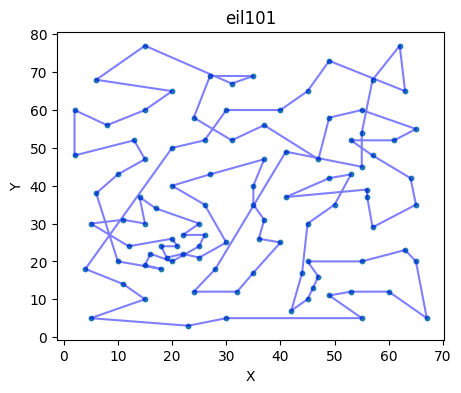

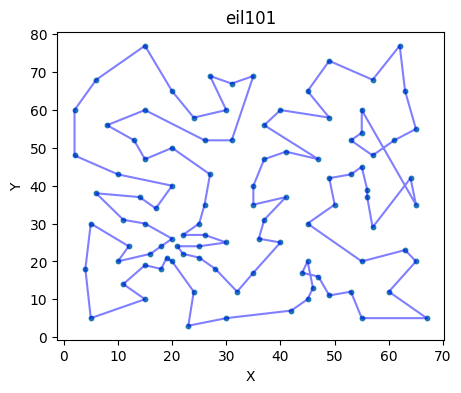

In [185]:
for i in range(len(best_solutions)):
    plot_TSP(g_eil101, best_solutions[i], 'eil101', i)